In [46]:
from snowflake.snowpark.session import Session
import json

In [47]:
with open("config.json", "r") as file:
    connection_parameters = json.load(file)

In [48]:
sess = Session.builder.configs( connection_parameters ).create()

KeyboardInterrupt: 

In [44]:
df_promos = sess.sql( '''
        SELECT 
            t2.*, 
            TRANSLATE(
                t3.DS_PROMO_PRIMERITI, 
                'áÁéÉíÍóÓúÚñÑ ', 
                'aAeEiIoOuUnN_'
            ) AS DS_PROMO_PRIMERITI
        FROM 
            CAA.STG_FCDP.TB_DEMAND_PLANNING_PRM_PRIMERITI AS t2
            INNER JOIN CAA.STG_FCDP.TB_DEMAND_PLANNING_PRM_MAESTRA_PRIMERITI AS t3
            ON t2.ID_PROMO_PRIMERITI = t3.ID_PROMO_PRIMERITI
''' ).to_pandas()

SnowparkFetchDataException: (1406): Failed to fetch a pandas Dataframe. The error is: 255002: Optional dependency: 'pandas' is not installed, please see the following link for install instructions: https://docs.snowflake.com/en/user-guide/python-connector-pandas.html#installation

## Imports

In [17]:
from neuralforecast.losses.pytorch import GMM, MQLoss, DistributionLoss, MAE, PMM
from neuralforecast.core import NeuralForecast
from utilsforecast.plotting import plot_series
from neuralforecast.models import BiTCN # DeepAR,TSMixerx, TiDE, MLP, TFT, RNN, TCN, MLPMultivariate, NBEATSx, DeepNPTS, NHITS, BiTCN,LSTM, DilatedRNN, KAN, GRU, PatchTST
from neuralforecast.tsdataset  import TimeSeriesDataset
import pandas as pd
import numpy as np
import logging

## Data Preparation

In [19]:
import pandas as pd

# Cargar datos
df = pd.read_csv('01_FEATURES_LIB.csv')

# Convertir a datetime
df['DT_FECHA'] = pd.to_datetime(df['DT_FECHA'])

# Crear nuevas columnas sumando dinámicamente
df['OI_BLACK_FRIDAY_CTE'] = df[['OI_BLACK_FRIDAY_FASE_1_CTE', 'OI_BLACK_FRIDAY_FASE_2_CTE']].sum(axis=1)
df['IN_CIERRE_90'] = df.filter(like='IN_CIERRE_90_M').sum(axis=1)
df['IN_CIERRE_50'] = df.filter(like='IN_CIERRE_50_M').sum(axis=1)

# Eliminar columnas utilizadas en la suma
cols_to_drop = ['OI_BLACK_FRIDAY_FASE_1_CTE', 'OI_BLACK_FRIDAY_FASE_2_CTE']
cols_to_drop += df.filter(like='IN_CIERRE_90_M').columns.tolist()
cols_to_drop += df.filter(like='IN_CIERRE_50_M').columns.tolist()
df.drop(columns=cols_to_drop, inplace=True)

# Renombrar columnas
df.rename(columns={'DT_FECHA': 'ds', 'LABEL': 'unique_id', 'QT_UNIDADES': 'y'}, inplace=True)

# Extraer el día de la semana 
# Opcional: Si prefieres Lunes=1 y Domingo=7, ajusta:
df["day_of_week"] = df["ds"].dt.dayofweek + 1  # 1: Lunes, 7: Domingo

# Codificación cíclica con seno y coseno
df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

# Lista de variables exógenas
exogenous_vars = [
    #'day_of_week',
    'day_sin',
    'day_cos',
    'DIC_17',
    'DIC_18',
    'DIC_19',
    'DIC_20',
    'DIC_21',
    'DIC_22',
    'DIC_23',
    'DIC_24',
    'DIC_26',
    'DIC_27',
    'DIC_28',
    'DIC_29',
    'DIC_30',
    'ENE_1',
    'ENE_2',
    'ENE_3',
    'ENE_4',
    'ENE_5',
    'ENE_6',
    'IN_CIERRE_90', 
    'IN_CIERRE_50', 
    'IN_FESTIVO', 
    'OI_8_DIAS_DE_ORO_CTE', 
    'OI_BLACK_FRIDAY_CTE',
    'OI_CYBER_MONDAY_CTE', 
    'OI_DIA_SIN_IVA_CTE', 
    'OI_INICIO_BLANCOLOR_CTE', 
    'OI_LIMITE_48_HORAS_FASE_1_CTE',
    'OI_LIMITE_48_HORAS_FASE_2_CTE', 
    'OI_LIMITE_48_HORAS_FASE_3_CTE', 
    'OI_LIMITE_48_HORAS_FASE_4_CTE',
    'OI_SEMANA_DEL_DEPORTE_CTE', 
    'OI_SEMANA_LENCERIA_CTE', 
    'OI_SUPERTECNOPRECIOS_CTE', 
    'OI_VENTAS_PRIVADAS_CTE',
    'PV_8_DIAS_DE_ORO_CTE', 
    'PV_LIMITE_48_HORAS_FASE_1_CTE', 
    'PV_LIMITE_48_HORAS_FASE_2_CTE',
    'PV_LIMITE_48_HORAS_FASE_3_CTE', 
    'PV_LIMITE_48_HORAS_FASE_4_CTE', 
    'PV_SEMANA_DE_INTERNET_CTE',
    'PV_VENTAS_PRIVADAS_CTE', 
    'VERANO_PERIODO_FINAL_CTE', 
    'VERANO_PRIMER_PERIODO_CTE', 
    'VERANO_SEGUNDO_PERIODO_CTE',
    'INVIERNO_PERIODO_FINAL_CTE', 
    'INVIERNO_PRIMER_PERIODO_CTE', 
    'INVIERNO_SEGUNDO_PERIODO_CTE', 
    'LIBROS_TEXTO_LIB'
]

# Seleccionar solo las columnas necesarias y ordenar
df = df[['unique_id', 'ds', 'y'] + exogenous_vars].sort_values(by=['unique_id', 'ds'])

dummies = pd.get_dummies(df['unique_id'], prefix='CAT')
df_with_dummies = pd.concat([df[['unique_id']], dummies], axis=1)
static_df  = df_with_dummies.groupby('unique_id').max().reset_index()
stat_exog_list = static_df.columns[1:].to_list()


In [121]:
# print(df[(df['ds'] >= '2024-11-20') & (df['ds'] <= '2024-12-03') & (df['unique_id'] == 'ENVIOS')][['ds', 'unique_id', 'OI_BLACK_FRIDAY_CTE']].sort_values(by='ds').to_string())

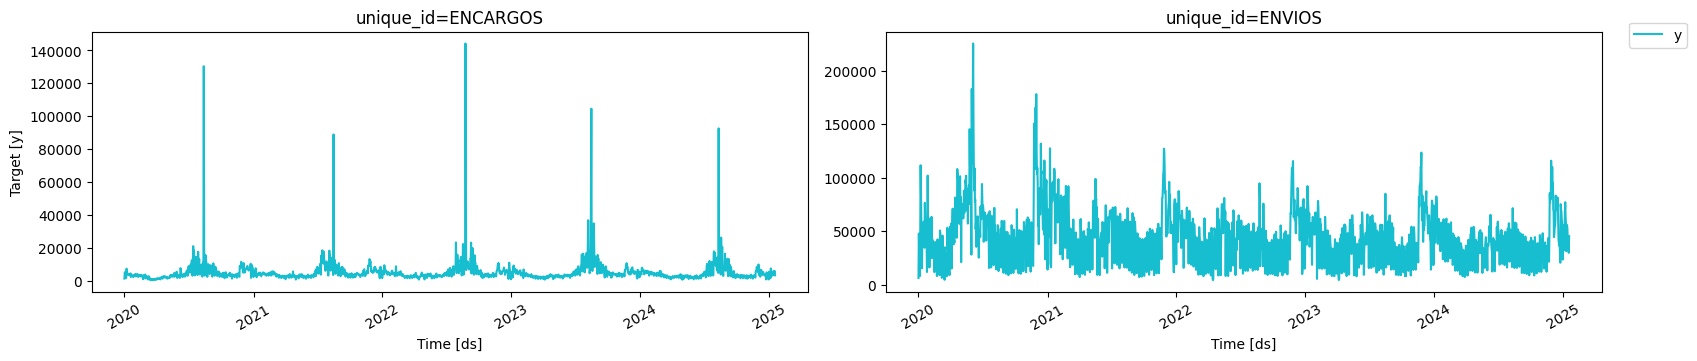

In [20]:
plot_series(df)

In [129]:
# print(df[df['unique_id'] == 'ENVIOS'].describe().to_string())

## Def Model

In [21]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [22]:
class CustomConv1d(nn.Module):
    """
    Forward- and backward looking Conv1D
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, dilation=1, mode='backward', groups=1):
        super().__init__()
        k = np.sqrt(1 / (in_channels * kernel_size))
        weight_data = -k + 2 * k * torch.rand((out_channels, in_channels // groups, kernel_size))
        bias_data = -k + 2 * k * torch.rand((out_channels))
        self.weight = nn.Parameter(weight_data, requires_grad=True)
        self.bias = nn.Parameter(bias_data, requires_grad=True)  
        self.dilation = dilation
        self.groups = groups
        if mode == 'backward':
            self.padding_left = padding
            self.padding_right= 0
        elif mode == 'forward':
            self.padding_left = 0
            self.padding_right= padding            

    def forward(self, x):
        xp = F.pad(x, (self.padding_left, self.padding_right))
        return F.conv1d(xp, self.weight, self.bias, dilation=self.dilation, groups=self.groups)

class TCNCell(nn.Module):
    """
    Temporal Convolutional Network Cell, consisting of CustomConv1D modules.
    """    
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation, mode, groups, dropout):
        super().__init__()
        self.conv1 = CustomConv1d(in_channels, out_channels, kernel_size, padding, dilation, mode, groups)
        self.conv2 = CustomConv1d(out_channels, in_channels * 2, 1)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        h_prev, out_prev = x
        h = self.drop(F.gelu(self.conv1(h_prev)))
        h_next, out_next = self.conv2(h).chunk(2, 1)
        return (h_prev + h_next, out_prev + out_next)

In [23]:
class BiTCN(BaseWindows):
    """ BiTCN

    Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This is a univariate model.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `hidden_size`: int=16, units for the TCN's hidden state size.<br>
    `dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>  
    - [Olivier Sprangers, Sebastian Schelter, Maarten de Rijke (2023). Parameter-Efficient Deep Probabilistic Forecasting. International Journal of Forecasting 39, no. 1 (1 January 2023): 332–45. URL: https://doi.org/10.1016/j.ijforecast.2021.11.011.](https://doi.org/10.1016/j.ijforecast.2021.11.011)<br>    

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True

    def __init__(self,
                 h: int,
                 input_size: int,
                 hidden_size: int = 16,
                 dropout: float = 0.5,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 dataloader_kwargs=None,
                 **trainer_kwargs):
        super(BiTCN, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            dataloader_kwargs=dataloader_kwargs,
            **trainer_kwargs
        )

        #----------------------------------- Parse dimensions -----------------------------------#
        # TCN
        kernel_size = 2  # Not really necessary as parameter, so simplifying the architecture here.
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.h = h
        self.input_size = input_size
        self.dropout = dropout
        
        # Calculate required number of TCN layers based on the required receptive field of the TCN
        self.n_layers_bwd = int(np.ceil(np.log2(((self.input_size - 1) / (self.kernel_size - 1)) + 1)))     
       
        #---------------------------------- Instantiate Model -----------------------------------#
        
        # Dense layers
        self.lin_hist = nn.Linear(1 + self.hist_exog_size + self.stat_exog_size + self.futr_exog_size, hidden_size)
        self.drop_hist = nn.Dropout(dropout)
        
        # TCN looking back
        layers_bwd = [TCNCell(
                        hidden_size, 
                        hidden_size, 
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'backward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_bwd)]      
        self.net_bwd = nn.Sequential(*layers_bwd)
        
        # TCN looking forward when future covariates exist
        output_lin_dim_multiplier = 1
        if self.futr_exog_size > 0:
            self.n_layers_fwd = int(np.ceil(np.log2(((self.h + self.input_size - 1) / (self.kernel_size - 1)) + 1)))
            self.lin_futr = nn.Linear(self.futr_exog_size, hidden_size)
            self.drop_futr = nn.Dropout(dropout)
            layers_fwd = [TCNCell(
                            hidden_size, 
                            hidden_size, 
                            kernel_size, 
                            padding = (kernel_size - 1)*2**i, 
                            dilation = 2**i, 
                            mode = 'forward', 
                            groups = 1, 
                            dropout = dropout) for i in range(self.n_layers_fwd)]             
            self.net_fwd = nn.Sequential(*layers_fwd)
            output_lin_dim_multiplier += 2

        # Dense temporal and output layers
        self.drop_temporal = nn.Dropout(dropout)
        self.temporal_lin1 = nn.Linear(self.input_size, hidden_size)
        self.temporal_lin2 = nn.Linear(hidden_size, self.h)
        self.output_lin = nn.Linear(output_lin_dim_multiplier * hidden_size, self.loss.outputsize_multiplier)

    def forward(self, windows_batch):
        # Parse windows_batch
        x             = windows_batch['insample_y'].unsqueeze(-1)       #   [B, L, 1]
        hist_exog     = windows_batch['hist_exog']                      #   [B, L, X]
        futr_exog     = windows_batch['futr_exog']                      #   [B, L + h, F]
        stat_exog     = windows_batch['stat_exog']                      #   [B, S]

        # Concatenate x with historic exogenous
        batch_size, seq_len = x.shape[:2]                               #   B = batch_size, L = seq_len
        if self.hist_exog_size > 0:
            x = torch.cat((x, hist_exog), dim=2)                        #   [B, L, 1] + [B, L, X] -> [B, L, 1 + X]

        # Concatenate x with static exogenous
        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1)    #   [B, S] -> [B, L, S]
            x = torch.cat((x, stat_exog), dim=2)                        #   [B, L, 1 + X] + [B, L, S] -> [B, L, 1 + X + S]

        # Concatenate x with future exogenous & apply forward TCN to x_futr
        if self.futr_exog_size > 0:
            x = torch.cat((x, futr_exog[:, :seq_len]), dim=2)           #   [B, L, 1 + X + S] + [B, L, F] -> [B, L, 1 + X + S + F]
            x_futr = self.drop_futr(self.lin_futr(futr_exog))           #   [B, L + h, F] -> [B, L + h, hidden_size]
            x_futr = x_futr.permute(0, 2, 1)                            #   [B, L + h, hidden_size] -> [B, hidden_size, L + h]
            _, x_futr = self.net_fwd((x_futr, 0))                       #   [B, hidden_size, L + h] -> [B, hidden_size, L + h]
            x_futr_L = x_futr[:, :, :seq_len]                           #   [B, hidden_size, L + h] -> [B, hidden_size, L]
            x_futr_h = x_futr[:, :, seq_len:]                           #   [B, hidden_size, L + h] -> [B, hidden_size, h]

        # Apply backward TCN to x
        x = self.drop_hist(self.lin_hist(x))                            #   [B, L, 1 + X + S + F] -> [B, L, hidden_size]
        x = x.permute(0, 2, 1)                                          #   [B, L, hidden_size] -> [B, hidden_size, L]
        _, x = self.net_bwd((x, 0))                                     #   [B, hidden_size, L] -> [B, hidden_size, L]

        # Concatenate with future exogenous for seq_len
        if self.futr_exog_size > 0:
            x = torch.cat((x, x_futr_L), dim=1)                         #   [B, hidden_size, L] + [B, hidden_size, L] -> [B, 2 * hidden_size, L]

        # Temporal dense layer to go to output horizon
        x = self.drop_temporal(F.gelu(self.temporal_lin1(x)))           #   [B, 2 * hidden_size, L] -> [B, 2 * hidden_size, hidden_size]
        x = self.temporal_lin2(x)                                       #   [B, 2 * hidden_size, hidden_size] -> [B, 2 * hidden_size, h]
        
        # Concatenate with future exogenous for horizon
        if self.futr_exog_size > 0:
            x = torch.cat((x, x_futr_h), dim=1)                         #   [B, 2 * hidden_size, h] + [B, hidden_size, h] -> [B, 3 * hidden_size, h]

        # Output layer to create forecasts
        x = x.permute(0, 2, 1)                                          #   [B, 3 * hidden_size, h] -> [B, h, 3 * hidden_size]
        x = self.output_lin(x)                                          #   [B, h, 3 * hidden_size] -> [B, h, n_outputs] 

        # Map to output domain
        forecast = self.loss.domain_map(x)
        
        return forecast

## Model

In [28]:
horizon = 103
max_steps = 10
val_check_steps=1
input_size = 5*horizon
dropout=0.1
learning_rate = 1e-2

train_cutoff = pd.Timestamp('2024-09-30') # '2024-09-30'
# train_cutoff = df['ds'].max() - pd.Timedelta(days=horizon) 
train_data = df[df['ds'] <= train_cutoff]
test_data = df[(df['ds'] > train_cutoff) & (df['ds'] <= train_cutoff + pd.Timedelta(days=horizon))]


In [25]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


In [16]:
# from nbdev.showdoc import show_doc
# show_doc(TiDE)
# show_doc(RNN.fit, name='RNN.fit')

In [29]:
models = [  BiTCN(h = horizon,
                input_size = input_size,
                max_steps=max_steps,
                futr_exog_list = exogenous_vars, 
                stat_exog_list = stat_exog_list,
                #hist_exog_list=, 
                scaler_type = 'robust',
                loss=PMM(n_components=5, return_params=True, level=[95]),
                # valid_loss=DistributionLoss(distribution='StudentT', level=[95]),
                # valid_loss=PMM(n_components=5, return_params=True, level=[95]),
                learning_rate = learning_rate,

                hidden_size=16,  
                dropout=dropout,

                alias = 'BiTCN_long',
                random_seed = 123,

                val_check_steps=val_check_steps, # def->100 Recomendable que sea menor a max_steps nro_validaciones = max_steps / val_check_steps 
                # early_stop_patience_steps=10
                  
                )

]

Seed set to 123


## Train

In [30]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train_data, static_df=static_df)


Epoch 9: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=156, train_loss_step=72646.5, train_loss_epoch=72646.5]


## Forecast

In [31]:
Y_hat_df = nf.predict(futr_df=test_data)
Y_hat_df = pd.merge(Y_hat_df, test_data[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')
Y_hat_df


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


,unique_id,ds,BiTCN_long,BiTCN_long-median,BiTCN_long-lo-95,BiTCN_long-hi-95,BiTCN_long-lambda-1,BiTCN_long-lambda-2,BiTCN_long-lambda-3,BiTCN_long-lambda-4,BiTCN_long-lambda-5,y
0,ENCARGOS,2024-10-01,2798.391113,2820.5,867.000000,3896.000000,2820.525391,3828.882080,2688.734863,897.458984,3571.422852,3739
1,ENCARGOS,2024-10-02,1833.948975,1784.5,91.974998,4908.049805,2154.226074,4821.113770,179.046875,104.450928,1783.412842,3393
2,ENCARGOS,2024-10-03,2532.497070,3325.5,803.950012,3676.000000,3597.313965,3527.781738,1549.592773,841.024170,3347.116699,2737
3,ENCARGOS,2024-10-04,3007.001953,2661.0,2038.974976,4490.024902,3702.298096,4423.886719,2090.328369,2655.738281,2217.198486,3836
4,ENCARGOS,2024-10-05,3.925000,0.0,0.000000,23.000000,18.770020,0.000000,0.000000,0.000000,0.000000,3044
...,...,...,...,...,...,...,...,...,...,...,...,...
201,ENVIOS,2025-01-07,54689.664062,56189.5,41436.851562,64825.375000,56136.062500,64489.105469,41603.328125,59809.085938,49951.250000,67886
202,ENVIOS,2025-01-08,53747.855469,50157.5,48845.851562,62103.175781,49135.867188,50171.835938,61799.179688,58445.960938,49336.507812,77124
203,ENVIOS,2025-01-09,51405.296875,46169.0,44013.976562,64511.074219,44310.511719,44414.460938,64248.703125,57549.085938,46163.449219,63212
204,ENVIOS,2025-01-10,48738.113281,44650.5,39513.875000,61345.199219,39724.601562,61083.257812,43962.714844,44612.261719,54025.664062,56912


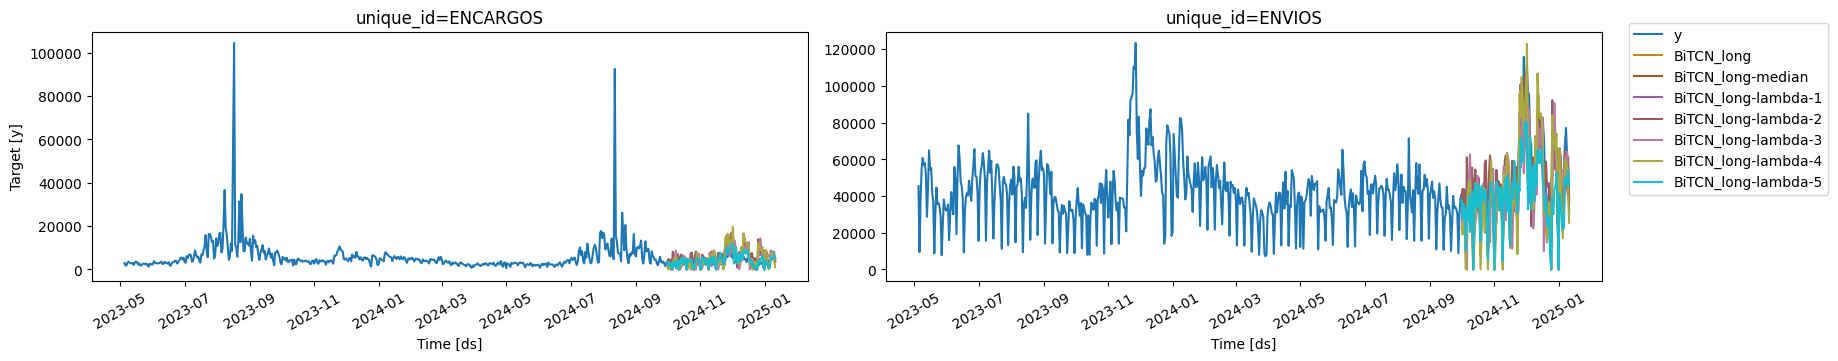

In [32]:
plot_series(train_data, Y_hat_df, max_insample_length=horizon*5)


In [33]:
import pandas as pd

# Supongamos que df es tu DataFrame
def calculate_metrics(df):
    # Identificar columnas de predicción
    prediction_cols = [col for col in df.columns if col not in ['unique_id', 'ds', 'y']]
    
    results = []

    # Agrupar por unique_id
    for unique_id, group in df.groupby('unique_id'):
        y_real = group['y'].values
        y_sum = abs(y_real).sum()

        # Calcular métricas para cada columna de predicción
        for col in prediction_cols:
            y_pred = group[col].values
            abs_error = abs(y_real - y_pred)
            
            wape = abs_error.sum() / y_sum if y_sum != 0 else None
            std_dev = abs_error.std()

            results.append({
                'unique_id': unique_id,
                'model': col,
                'WAPE': wape,
                'StdDev_Error': std_dev
            })
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Aplicar la función al DataFrame
metrics_df = calculate_metrics(Y_hat_df)


print(metrics_df.to_string())

   unique_id                model      WAPE  StdDev_Error
0   ENCARGOS           BiTCN_long  0.586354   1835.115474
1   ENCARGOS    BiTCN_long-median  0.596394   1795.111645
2   ENCARGOS     BiTCN_long-lo-95  0.512183   1280.646842
3   ENCARGOS     BiTCN_long-hi-95  1.219457   2881.196558
4   ENCARGOS  BiTCN_long-lambda-1  0.555115   1704.483293
5   ENCARGOS  BiTCN_long-lambda-2  0.892755   2443.381847
6   ENCARGOS  BiTCN_long-lambda-3  0.782263   2191.042454
7   ENCARGOS  BiTCN_long-lambda-4  0.824151   2753.975730
8   ENCARGOS  BiTCN_long-lambda-5  0.537757   1376.380757
9     ENVIOS           BiTCN_long  0.173675   8782.636518
10    ENVIOS    BiTCN_long-median  0.191745   9561.045412
11    ENVIOS     BiTCN_long-lo-95  0.355466  13518.211385
12    ENVIOS     BiTCN_long-hi-95  0.297411   7875.045710
13    ENVIOS  BiTCN_long-lambda-1  0.208317   9869.477189
14    ENVIOS  BiTCN_long-lambda-2  0.252915  10461.811394
15    ENVIOS  BiTCN_long-lambda-3  0.295160  11375.786159
16    ENVIOS  

In [34]:
# Ordenar por unique_id y WAPE
metrics_df_sorted = metrics_df.sort_values(by=['unique_id', 'WAPE'])

# Obtener el modelo con menor WAPE para cada unique_id
best_models_df = metrics_df_sorted.groupby('unique_id').first().reset_index()

best_models_df

,unique_id,model,WAPE,StdDev_Error
0,ENCARGOS,BiTCN_long-lo-95,0.512183,1280.646842
1,ENVIOS,BiTCN_long,0.173675,8782.636518


In [38]:
import plotly.express as px
import plotly.io as pio
import os  # Para manejar rutas y nombres de archivo

pio.renderers.default = "browser"

def plot_predictions(df, unique_id, save_path=None, file_name=None):
    """
    Genera un gráfico interactivo para un único unique_id mostrando y y las predicciones, 
    y opcionalmente guarda la gráfica como archivo HTML.
    
    Args:
        df (pd.DataFrame): DataFrame con las columnas 'unique_id', 'ds', 'y' y las predicciones.
        unique_id (str): Identificador único para filtrar los datos.
        save_path (str, optional): Ruta donde guardar la gráfica. Default: None.
        file_name (str, optional): Nombre del archivo HTML. Default: None.
    """
    # Filtrar el DataFrame por unique_id
    df_filtered = df[df['unique_id'] == unique_id]

    # Transformar a formato largo para graficar fácilmente
    prediction_cols = [col for col in df.columns if col not in ['unique_id', 'ds', 'y']]
    df_long = df_filtered.melt(id_vars=['ds', 'y'], 
                               value_vars=prediction_cols, 
                               var_name='Model', 
                               value_name='Prediction')

    # Crear gráfico interactivo
    fig = px.line(df_long, 
                  x='ds', 
                  y='Prediction', 
                  color='Model',
                  title=f'Predicciones para unique_id: {unique_id}',
                  labels={'ds': 'Fecha', 'Prediction': 'Valor'},
                  template='plotly_white')
    
    # Agregar la serie real (y)
    fig.add_scatter(x=df_filtered['ds'], 
                    y=df_filtered['y'], 
                    mode='lines', 
                    name='Real', 
                    line=dict(color='black', dash='dash'))
    
    # Mostrar la gráfica
    fig.show()

    # Guardar la gráfica como HTML si se especifica una ruta
    if save_path and file_name:
        # Crear la carpeta si no existe
        os.makedirs(save_path, exist_ok=True)
        
        # Ruta completa del archivo
        file_path = os.path.join(save_path, file_name)
        
        # Guardar gráfica como HTML
        try:
            fig.write_html(file_path)
            print(f"Gráfica interactiva guardada en: {file_path}")
        except Exception as e:
            print(f"Error al guardar la gráfica como HTML: {e}")


## Plot Fore

In [40]:
idx = 'ENVIOS'  # ENCARGOS ENVIOS
modelo = 'BiTCN_BEST'
plot_predictions(Y_hat_df, unique_id=idx) # save_path='./graficas', file_name=f'{idx}_{modelo}.html'

## Forecast whitout BF

In [144]:
test_data_sbf = test_data.copy()
mask = (test_data_sbf['ds'] >= '2024-11-25') & (test_data_sbf['ds'] <= '2024-12-02')

# Lista de columnas a poner en cero
columns_to_zero = [
    'OI_BLACK_FRIDAY_CTE'
]

# Poner en cero las columnas especificadas en el rango de fechas
test_data_sbf.loc[mask, columns_to_zero] = 0

In [145]:
Y_hat_df_sbf = nf.predict(futr_df=test_data_sbf)
Y_hat_df_sbf = pd.merge(Y_hat_df_sbf, test_data_sbf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')
Y_hat_df_sbf

Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,BiTCN_long,BiTCN_long-median,BiTCN_long-lo-95,BiTCN_long-hi-95,BiTCN_long-lambda-1,BiTCN_long-lambda-2,BiTCN_long-lambda-3,BiTCN_long-lambda-4,BiTCN_long-lambda-5,y
0,ENCARGOS,2024-10-01,4736.827148,3820.0,0.000000,14583.099609,14456.109375,0.000000,5377.902344,3810.967529,0.000000,3739
1,ENCARGOS,2024-10-02,3843.176025,1575.0,0.000000,12999.025391,12874.099609,0.000000,4811.566406,1577.806152,0.000000,3393
2,ENCARGOS,2024-10-03,3216.125000,201.0,0.000000,12315.125000,12196.590820,0.000000,4046.488770,200.692627,0.000000,2737
3,ENCARGOS,2024-10-04,5630.288086,3447.0,0.000000,18424.025391,18267.617188,0.000000,6378.828125,3455.451416,0.000000,3836
4,ENCARGOS,2024-10-05,3379.267090,0.0,0.000000,14304.000000,14138.459961,0.000000,1981.104492,0.000000,0.000000,3044
...,...,...,...,...,...,...,...,...,...,...,...,...
201,ENVIOS,2025-01-07,65671.531250,66347.5,40747.949219,88349.171875,87991.656250,84358.906250,46224.015625,66271.812500,40965.507812,67886
202,ENVIOS,2025-01-08,62972.503906,63312.5,42961.976562,85317.078125,84989.140625,74571.304688,43592.664062,63228.867188,43205.761719,77124
203,ENVIOS,2025-01-09,58942.460938,60131.5,38950.675781,88016.046875,87710.281250,62735.695312,45417.648438,60120.039062,39175.289062,63212
204,ENVIOS,2025-01-10,50449.691406,44011.5,36802.898438,79996.203125,79639.828125,44025.328125,41401.582031,51837.675781,37049.222656,56912


In [146]:
Y_hat_df_sbf['unique_id'].unique()

array(['ENCARGOS', 'ENVIOS'], dtype=object)

## Plot Fore without BF

In [148]:
idx = 'ENCARGOS'
modelo = 'BiTCN_BEST'
plot_predictions(Y_hat_df_sbf, unique_id=idx, save_path='./graficas', file_name=f'{idx}_{modelo}_NOBF_1000.html') # save_path='./graficas', file_name=f'{idx}_{modelo}_NOBF.html'


Gráfica interactiva guardada en: ./graficas\ENCARGOS_BiTCN_BEST_NOBF_1000.html


In [79]:
# Y_hat_df.to_csv(f'RESULTADOS_{modelo}.csv', index=False)